In [ ]:
# default_exp models

# Models

> Tree ensemble and decision tree models.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#export
from decision_tree.imports import *
from decision_tree.core import *
from decision_tree.data import *

## Decision Tree

In [ ]:
#export
class Node():
    def __init__(self, depth, pred, sample_idxs, split_score=np.inf):
        self.depth, self.pred, self.sample_idxs, self.split_score = \
            depth, pred, sample_idxs, split_score
        
    def __repr__(self):
        res = f'Node({self.depth}, {r3(self.pred)}, {self.sample_idxs}'
        if self.split_score != np.inf: 
            res += f', {r3(self.split_score)}, {self.split_col_idx}, {r3(self.split_values)}, {self.split_idxs}, {r3(self.split_preds)}'
        return res + ')'

In [ ]:
assert np.inf == Node(1, 0.9, [1,2,3]).split_score

In [ ]:
#export
def best_split_for_col(data, node, col_idx, min_leaf_samples=None):
    "Returns the best split that can be made for this column/node"
    _min_leaf = min_leaf_samples if min_leaf_samples else 1
    x, y = data.get_sample(node.sample_idxs, col_idx)
    sort_idx = np.argsort(x)
    x, y = x[sort_idx], y[sort_idx]
    aggs = Aggs(y)
    stop = len(x) - _min_leaf
    for i in range(stop):
        aggs.upd(y[i])
        if x[i] == x[i+1] or i < _min_leaf-1: continue
        score = aggs.score()
        if score < node.split_score: 
            node.split_score, node.split_col_idx = score, col_idx
            node.split_values = x[i], x[i+1]
            node.split_idxs = split_array(node.sample_idxs[sort_idx], i+1)
            node.split_preds = tuple(arr.mean() for arr in split_array(y, i+1))

In [ ]:
test_x = np.array(
    [[23.2, 44.4], #0
     [ 2. ,  2. ], #1
     [34.3, 77.3], #2
     [-1.5, -0.5], #3
     [ 1.5,  1.5], #4
     [ 1.5,  9.2], #5
     [ 2. , -2. ]])#6
test_y = np.array([0.0, 1.1, 2.2, 3.3, 4.4, 5.5, 6.6])
test_data = DataWrapper.from_pandas(pd.DataFrame(test_x), pd.Series(test_y))

test_node = Node(0, 0, np.arange(7))
best_split_for_col(test_data, test_node, 0, 3)
le_split, gt_split = test_node.split_idxs
assert np.array_equal(test_y[le_split], [3.3, 4.4, 5.5])
assert np.array_equal(test_y[gt_split], [1.1, 6.6, 0. , 2.2])

test_node = Node(0, 0, np.arange(7))
best_split_for_col(test_data, test_node, 1)
le_split, gt_split = test_node.split_idxs
assert np.array_equal(test_y[le_split], [6.6])
assert np.array_equal(test_y[gt_split], [3.3, 4.4, 1.1, 5.5, 0. , 2.2])

# not enough data to split with at least 4 values in each leaf
test_node = Node(0, 0, np.arange(7))
best_split_for_col(test_data, test_node, 1, 4)
assert test_node.split_score == np.inf

test_node = Node(0, 0, np.arange(7)[4:])
test_split = best_split_for_col(test_data, test_node, 0, 1)
le_split, gt_split = test_node.split_idxs
assert np.array_equal(test_y[le_split], [4.4, 5.5])
assert np.array_equal(test_y[gt_split], [6.6])
assert test_node.split_values == (1.5, 2.0)

In [ ]:
#export
def best_split(data, node, col_idxs, min_leaf_samples=None):
    for col_idx in col_idxs: best_split_for_col(data, node, col_idx, min_leaf_samples)

In [ ]:
test_node = Node(0, 0, np.arange(7))
best_split(test_data, test_node, [0,1]); test_split
assert test_node.split_col_idx == 1
assert test_node.split_preds == (6.6, 2.75)

In [ ]:
#export
class DecisionTree():
    def __init__(self, data, max_depth=None, min_leaf_samples=3, col_idxs_fn=None):
        self.data, self.max_depth, self.min_leaf_samples, self.col_idxs_fn = \
            data, max_depth, min_leaf_samples, col_idxs_fn
    
    def _col_idxs(self):
        return self.col_idxs_fn(self.data.all_x_col_idxs) if self.col_idxs_fn else self.data.all_x_col_idxs
    
    def _recursive_split(self, node):
        best_split(self.data, node, self._col_idxs(), self.min_leaf_samples)
        if node.split_score == np.inf: return
        for op, value, idxs, pred in zip(['le', 'gt'], node.split_values, node.split_idxs, node.split_preds):
            setattr(node, op, Node(node.depth+1, pred, idxs))
            self._recursive_split(getattr(node, op))
        
    def fit(self):
        self.node = Node(1, self.data.y.mean(), self.data.all_x_row_idxs)
        self._recursive_split(self.node)
        return self
    
    def predict_row(self, row):
        return predict_row(row, self.node)
    
    def predict(self, rows): 
        return np.array([self.predict_row(rows[i]) for i in range(len(rows))])
    
    def __repr__(self):
        return f'dTree(data={self.data} max_depth={self.max_depth} min_leaf_samples={self.min_leaf_samples})'

In [ ]:
#export
def print_tree(tree):
    "print tree with splits, depth first"
    print(tree)
    print('col_idxs_fn', tree.col_idxs_fn if tree.col_idxs_fn else 'default')
    if not hasattr(tree, 'node'): return
    queue = [tree.node]
    while len(queue) != 0:
        node = queue.pop(0)
        print(node)
        for k in ['le', 'gt']:
            if getattr(node, k, False): queue.append(getattr(node, k))

In [ ]:
print(test_y)
print_tree(DecisionTree(test_data, min_leaf_samples=2).fit())

[0.  1.1 2.2 3.3 4.4 5.5 6.6]
dTree(data=DataWrapper(x:[0 1] y:y, len:7) max_depth=None min_leaf_samples=2)
col_idxs_fn default
Node(1, 3.3, [0 1 2 3 4 5 6], 11.663, 0, (2.0, 23.2), (array([3, 4, 5, 1, 6]), array([0, 2])), (4.18, 1.1))
Node(2, 4.18, [3 4 5 1 6], 8.194, 0, (1.5, 2.0), (array([3, 4, 5]), array([1, 6])), (4.4, 3.85))
Node(2, 1.1, [0 2])
Node(3, 4.4, [3 4 5])
Node(3, 3.85, [1 6])


In [ ]:
print_tree(DecisionTree(test_data, min_leaf_samples=1).fit())

dTree(data=DataWrapper(x:[0 1] y:y, len:7) max_depth=None min_leaf_samples=1)
col_idxs_fn default
Node(1, 3.3, [0 1 2 3 4 5 6], 11.272, 1, (-2.0, -0.5), (array([6]), array([3, 4, 1, 5, 0, 2])), (6.6, 2.75))
Node(2, 6.6, [6])
Node(2, 2.75, [3 4 1 5 0 2], 5.389, 0, (1.5, 2.0), (array([3, 4, 5]), array([1, 0, 2])), (4.4, 1.1))
Node(3, 4.4, [3 4 5], 1.1, 1, (1.5, 9.2), (array([3, 4]), array([5])), (3.85, 5.5))
Node(3, 1.1, [1 0 2], 1.1, 0, (23.2, 34.3), (array([1, 0]), array([2])), (0.55, 2.2))
Node(4, 3.85, [3 4], 0, 0, (-1.5, 1.5), (array([3]), array([4])), (3.3, 4.4))
Node(4, 5.5, [5])
Node(4, 0.55, [1 0], 0, 0, (2.0, 23.2), (array([1]), array([0])), (1.1, 0.0))
Node(4, 2.2, [2])
Node(5, 3.3, [3])
Node(5, 4.4, [4])
Node(5, 1.1, [1])
Node(5, 0.0, [0])


TODO: xxxx clean-up

Might we be able to generalize better by ;
- adding a little randomness by using a split value that lies somewhere between the lower and upper boundary of the split. See np.random.uniform ...
- use the average of the lower and upper boundary values

both of these could be done at prediction time

In [ ]:
#export
def predict_row(row, node):
    "make a prediction for the specified row, using the specified node"
    if node.split_score == np.inf: return node.pred
    split_value = node.split_values[0] # TODO: use just lower value for now
    split_col_idx = node.split_col_idx
    row_value = row[split_col_idx]
    next_node = node.le if row_value<=split_value else node.gt
    return predict_row(row, next_node)

When we make a prediction for a row that was used in training and we have only 1 sample in each leaf, the tree should predict exactly the right answer
- grab a single row of data
- make a prediction for this row
- assert that the prediction we made matches the actual for this row

In [ ]:
test_tree = DecisionTree(test_data, min_leaf_samples=1).fit()
for i in range(test_data.x_rows):
    test_sample = test_data.get_sample(i)
    assert predict_row(test_sample[0], test_tree.node) == test_sample[1]

Set-up some data for testing. This data is copied from the final model used in https://github.com/fastai/fastai/tree/master/courses/ml1/lesson2-rf_interpretation.ipynb

In [ ]:
bulldozers_data = np.load('test/data/bulldozers.npy', allow_pickle=True)
train_data = DataWrapper(*bulldozers_data[:4])
valid_data = DataWrapper(*bulldozers_data[4:])
train_data, valid_data

(DataWrapper(x:['YearMade' 'Coupler_System' 'ProductSize' 'fiProductClassDesc' 'ModelID'
  'saleElapsed' 'fiSecondaryDesc' 'fiModelDesc' 'Enclosure'
  'fiModelDescriptor' 'Hydraulics_Flow' 'Drive_System' 'ProductGroup'
  'Track_Type' 'state' 'saleDay' 'ProductGroupDesc' 'age'] y:SalePrice, len:389125),
 DataWrapper(x:['YearMade' 'Coupler_System' 'ProductSize' 'fiProductClassDesc' 'ModelID'
  'saleElapsed' 'fiSecondaryDesc' 'fiModelDesc' 'Enclosure'
  'fiModelDescriptor' 'Hydraulics_Flow' 'Drive_System' 'ProductGroup'
  'Track_Type' 'state' 'saleDay' 'ProductGroupDesc' 'age'] y:SalePrice, len:12000))

Use a very small amount of data to train a decision tree, then print the root node so we can see how the data has been split.

It's interesting that the depth of this tree is greater than the expected `np.log2(test_tree.data.x_rows)` - because it's unbalanced.

In [ ]:
test_tree = DecisionTree(train_data.tail(10), min_leaf_samples=1).fit()
print_tree(test_tree)

dTree(data=DataWrapper(x:['YearMade' 'Coupler_System' 'ProductSize' 'fiProductClassDesc' 'ModelID'
 'saleElapsed' 'fiSecondaryDesc' 'fiModelDesc' 'Enclosure'
 'fiModelDescriptor' 'Hydraulics_Flow' 'Drive_System' 'ProductGroup'
 'Track_Type' 'state' 'saleDay' 'ProductGroupDesc' 'age'] y:SalePrice, len:10) max_depth=None min_leaf_samples=1)
col_idxs_fn default
Node(1, 10.1, [0 1 2 3 4 5 6 7 8 9], 2.348, 6, (48, 107), (array([8, 9, 0]), array([2, 3, 7, 1, 4, 5, 6])), (9.263, 10.459))
Node(2, 9.263, [8 9 0], 0.105, 13, (0, 1), (array([0]), array([9, 8])), (9.473, 9.158))
Node(2, 10.459, [2 3 7 1 4 5 6], 1.013, 9, (0, 9), (array([2, 3, 7, 4, 5]), array([6, 1])), (10.316, 10.815))
Node(3, 9.473, [0])
Node(3, 9.158, [9 8], 0, 5, (1271894400, 1278979200), (array([9]), array([8])), (9.105, 9.21))
Node(3, 10.316, [2 3 7 4 5], 0.394, 4, (209, 216), (array([2]), array([3, 7, 5, 4])), (10.043, 10.384))
Node(3, 10.815, [6 1], 0, 0, (2003, 2007), (array([6]), array([1])), (10.714, 10.915))
Node(4, 9.

Get predictions for all of the data we trained on. 

Although we set `min_leaf_samples=1`, not every sample has it's own leaf. If 2 or more samples have;
- the same values for all independent variables and
- different values for the dependent variable,
- they will end up in the same leaf (because we can't find a value to split on) that will predict the mean of the dependent variables for all samples in the leaf

So we expect preds to be nearly 100% correct;
- loss to be nearly zero
- predictions vs actual plots a strait line with just a little variation

loss 0.030431982730330664


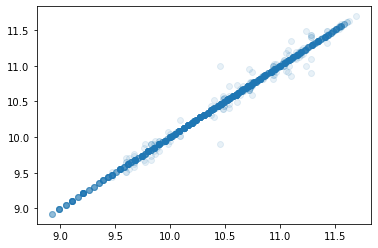

In [ ]:
test_tree = DecisionTree(train_data.tail(2000), min_leaf_samples=1).fit()
test_preds = test_tree.predict(test_tree.data.x)
loss = rmse(test_preds, test_tree.data.y); print('loss', loss)
import matplotlib.pyplot as plt
plt.scatter(test_preds, test_tree.data.y, alpha=.1);

Get predictions for all of the data we trained on again - but allow a minimum of 5 items in each leaf. So we see;
- a non-zero loss
- some variance in the predictions vs actual plot

loss 0.20120633092246643


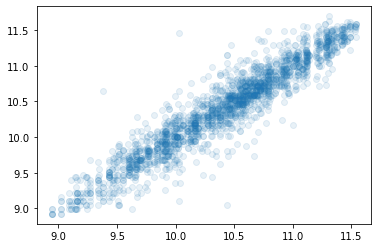

In [ ]:
test_tree = DecisionTree(train_data.tail(2000), min_leaf_samples=5).fit()
test_preds = test_tree.predict(test_tree.data.x)
loss = rmse(test_preds, test_tree.data.y); print('loss', loss)
plt.scatter(test_preds, test_tree.data.y, alpha=.1);

Get predictions for the validation data - we don't expect a single tree to be very good

loss 0.5382252356612661


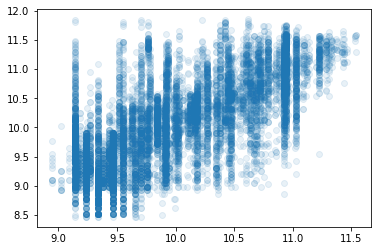

In [ ]:
test_preds = test_tree.predict(valid_data.x)
loss = rmse(test_preds, valid_data.y); print('loss', loss)
plt.scatter(test_preds, valid_data.y, alpha=.1);

## Tree Ensemble (AKA Random Forest)

In [ ]:
#export
class TreeEnsemble():
    def __init__(self, data, sample_size, max_depth=None, min_leaf_samples=3, n_trees=10, col_idxs_fn=None):
        self.data, self.sample_size, self.max_depth, self.min_leaf_samples, self.n_trees = \
                data, sample_size, max_depth, min_leaf_samples, n_trees
        if col_idxs_fn is None:
            n_cols = int(data.x_cols*0.5)
            self.col_idxs_fn = partial(np.random.choice, size=n_cols, replace=False)
        self.trees = []
        for i in range(n_trees):
            sample_idxs = np.random.permutation(data.x_rows)[:sample_size]
            sample_data = DataWrapper.from_data_wrapper(data, sample_idxs)
            self.trees.append(DecisionTree(sample_data, max_depth, min_leaf_samples, col_idxs_fn))
    
    def fit(self, max_workers=12):
        if max_workers == 0:
            [t.fit() for t in self.trees]
        else:
            with ProcessPoolExecutor(max_workers=max_workers) as executor:
                self.trees = list(executor.map(DecisionTree.fit, self.trees))
        return self
    
    def predict_row(self, row):
        return np.array([t.predict_row(row) for t in self.trees]).mean()
    
    def predict(self, rows): 
        return np.array([self.predict_row(rows[i]) for i in range(len(rows))])
    
    def __repr__(self):
        return f'tEnsemble(data={self.data} n_trees={self.n_trees} sample_size={self.sample_size} max_depth={self.max_depth} min_leaf_samples={self.min_leaf_samples})'

Create a tree ensemble and check that it has initialized correctly

In [ ]:
test_ensemble = TreeEnsemble(train_data.tail(2000), sample_size=750, min_leaf_samples=5)
assert test_ensemble.sample_size == 750 == test_ensemble.trees[0].data.x_rows == len(test_ensemble.trees[0].data.y)
assert len(test_ensemble.col_idxs_fn(test_ensemble.data.all_x_col_idxs)) == 9
assert len(test_ensemble.trees) == 10

Fit the ensemble and get predictions for all of the data we trained on - TODO: I'd expect this to be better than a single tree but the loss is the same. 


loss 0.2480154118352909


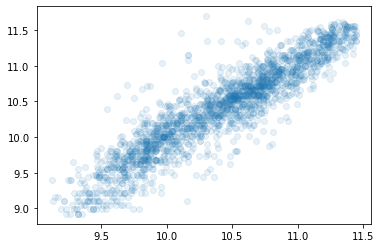

In [ ]:
test_ensemble.fit()
test_preds = test_ensemble.predict(test_ensemble.data.x)
loss = rmse(test_preds, test_ensemble.data.y); print('loss', loss)
plt.scatter(test_preds, test_ensemble.data.y, alpha=.1);

Get predictions for the validation data - expect this to be better than a single tree.

loss 0.5470735467070118


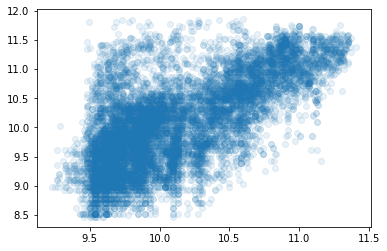

In [ ]:
test_preds = test_ensemble.predict(valid_data.x)
loss = rmse(test_preds, valid_data.y); print('loss', loss)
plt.scatter(test_preds, valid_data.y, alpha=.1);

TODO


- add classification capability


- confidence based on tree pred variance
- feature importance
    - jumble single column -> create preds - which column makes preds the worst when jumbled
    - WHAT are you forgetting?
        - is it which split/feature contributes the biggest change from "bias" to "pred"
    - avg depth of feature in tree <- i just made this up
- show dendogram of rank correlation
- partial dependence
    - ggplot if monotonic relationship
    - do the "what if" preds - i.e. change year of sale to 1960 and see what things would have sold for
    - pdp plot
- tree interpret
    - for single row pred: print contribution of each split (feature) to final result
    - waterfall chart